In [1]:
#%matplotlib
import numpy as np
pi = np.pi
from qutip import *
from qutip.qip.circuit import QubitCircuit, Gate
from qutip.qip.operations import *
from qip.kpoprocessor import KPOProcessor
import scipy.io as spio

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
%load_ext autoreload
%autoreload 2

<a href="#Ry">Ry</a>

In [2]:
# Problem
J = -1*np.array([[1,1/2],[1/2,1/2]])
h = -1*np.array([1/2,0])

# Eigvals [2 1 0 1]

# Number of qubits in the system
N = 2

In [3]:
name = 'instance_5_1_simple'
mat = spio.loadmat('../../Matlab/matqaoa/jeppesen_instances_simple/' + name + '.mat')
instance = mat['instance']
eigvals = instance['eigvals']
N = instance['size'][0][0][0][0]
J = instance['J'][0][0]
h = np.array(instance['h'][0][0]).flatten()
costs = np.array(eigvals[0][0]).flatten()

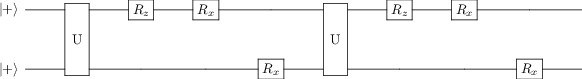

In [6]:
def carb(arg_value):
    # control arbitrary phase gate
    zz = tensor(sigmaz(),sigmaz())
    return (-1j*arg_value/2*zz).expm()

# Iteration level
p = 2

if p == 1:
    # Angles p = 1
    gamma = [0.9046]
    beta = [2.6893]
elif p == 2:    
    # Angles p = 2
    gamma = [pi/2, pi/2]
    beta = [2.3562, 2.3562]

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N, reverse_states = False)
qc.user_gates = {"CARB": carb}
qc.add_state(state = "+", targets = range(N), state_type = "input")

for i in range(p):
    for j in range(N-1):
        for k in range(j+1,N):
            if J[j][k] != 0:
                qc.add_gate("CARB", targets = [j,k], arg_value = 2*gamma[i]*J[j][k])
    for j in range(N):
        if h[j] != 0: 
            qc.add_gate("RZ", j, None, 2*gamma[i]*h[j])
        if 2*beta[i] > np.pi:
            qc.add_gate("RX", j, None, 2*np.pi - 2*beta[i])
            #qc.add_gate("RZ", j, None, 2*np.pi)

qc.png

In [7]:
kpo = KPOProcessor(N = N)
tlist, coeffs = kpo.load_circuit(qc)
print("Total time = %s (1/K)" % round(tlist[-1]))

Total time = 28.0 (1/K)


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff920192760>)

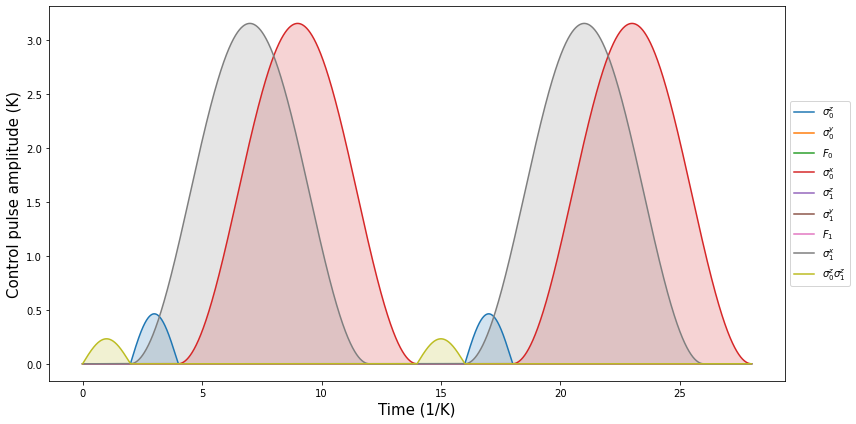

In [8]:
kpo.plot_pulses()

## Setup parameters and initial values

In [17]:
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']
eye = qeye(num_lvl)

# Cat state
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

# computational basis
up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

# initial state
plus = cat_plus
psi0 = tensor([plus for i in range(N)])

## Run master equation

In [18]:
# simulate
result = kpo.run_state(init_state = psi0, noisy = False)
final_state = result.states[-1]

## Calculate success probability

In [19]:
target_state = tensor(down,up)
if final_state.type == 'ket':
    f = (target_state.dag() * final_state).full()[0][0]
    f = abs(f)**2
else:
    f = abs((target_state.dag() * final_state * target_state).full()[0][0])
print("Success Probability = %s %%" % round(f*100,3))

Success Probability = 50.009 %


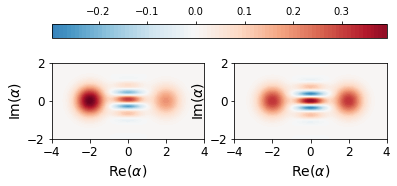

In [20]:
q0 = final_state.ptrace(0)
q1 = final_state.ptrace(1)
xvec = np.linspace(-4, 4, 400); yvec = np.linspace(-2, 2, 200)
W0 = wigner(q0,xvec,yvec,'iterative',2)
W1 = wigner(q1,xvec,yvec,'iterative',2)
nrm = mpl.colors.Normalize(-W0.max(), W0.max()) # Normalize colors

# contour plot
plt.subplot(121,aspect='equal')
im = plt.contourf(xvec, yvec, W0, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# contour plot
plt.subplot(122,aspect='equal')
im = plt.contourf(xvec, yvec, W1, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# colorbar
cax = plt.axes([0.125, 0.72, 0.775, 0.05]) # left, bottom, width, height
plt.colorbar(im, cax = cax, orientation = 'horizontal', ticklocation = 'top', ticks = np.arange(round(W0.min())-1,round(W0.max()+.1)+.1,0.1));

## <a name="Ry">QAOA but with a $R_y$-gate</a>

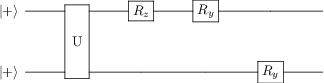

In [3]:
def carb(arg_value):
    # control arbitrary phase gate
    zz = tensor(sigmaz(),sigmaz())
    return (-1j*arg_value/2*zz).expm()

# Iteration level
p = 1

if p == 1:
    # Angles p = 1
    gamma = [np.pi]
    beta = [0.7823]
elif p == 2:    
    # Angles p = 2
    gamma = [np.pi/2, np.pi/2]
    beta = [-0.7854, -0.7854]

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N, reverse_states = False)
qc.user_gates = {"CARB": carb}
qc.add_state(state = "+", targets = range(N), state_type = "input")

for i in range(p):
    for j in range(N-1):
        for k in range(j+1,N):
            if J[j][k] != 0:
                qc.add_gate("CARB", targets = [j,k], arg_value = 2*gamma[i]*J[j][k])
    for j in range(N):
        if h[j] != 0: 
            qc.add_gate("RZ", j, None, 2*gamma[i]*h[j])
        qc.add_gate("RY", j, None, 2*beta[i])

qc.png

In [4]:
kpo = KPOProcessor(N = N)
tlist, coeffs = kpo.load_circuit(qc)
print("Total time = %s (1/K)" % round(tlist[-1]))

Total time = 9.0 (1/K)


In [5]:
len(tlist)

9142

In [6]:
len(coeffs[0])

9142

(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcb8990a250>)

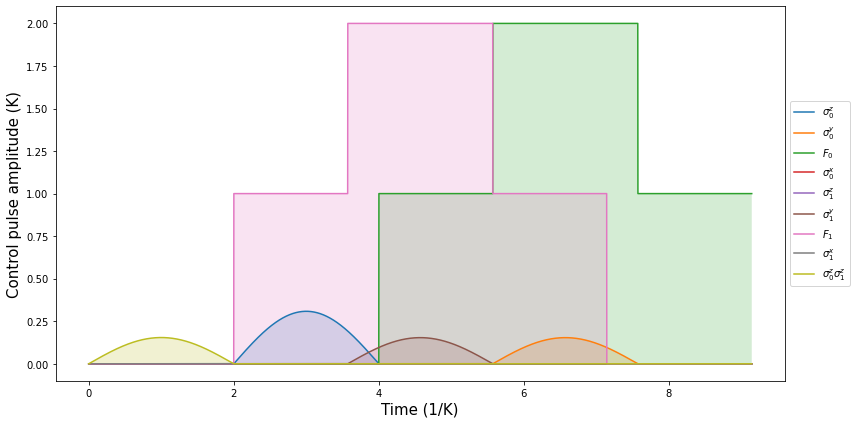

In [7]:
kpo.plot_pulses()

## Setup parameters and initial values

In [8]:
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']
eye = qeye(num_lvl)

# computational basis
up = coherent(num_lvl, alpha) # logical zero
down = coherent(num_lvl,-alpha) # logical one

# initial state
plus = (up+down).unit()
psi0 = tensor([plus for i in range(N)])

## Run master equation

In [9]:
# simulate
result = kpo.run_state(init_state = psi0, noisy = False)
final_state = result.states[-1]

## Calculate success probability

In [10]:
target_state = tensor(down,up)
if final_state.type == 'ket':
    f = (target_state.dag() * final_state).full()[0][0]
    f = abs(f)**2
else:
    f = abs((target_state.dag() * final_state * target_state).full()[0][0])
print("Success Probability = %s %%" % round(f*100,3))

Success Probability = 99.99 %


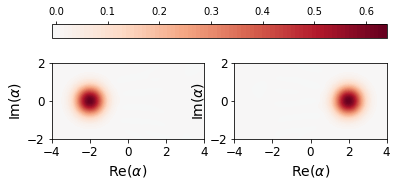

In [11]:
q0 = final_state.ptrace(0)
q1 = final_state.ptrace(1)
xvec = np.linspace(-4, 4, 400); yvec = np.linspace(-2, 2, 200)
W0 = wigner(q0,xvec,yvec,'iterative',2)
W1 = wigner(q1,xvec,yvec,'iterative',2)
nrm = mpl.colors.Normalize(-W0.max(), W0.max()) # Normalize colors

# contour plot
plt.subplot(121,aspect='equal')
im = plt.contourf(xvec, yvec, W0, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# contour plot
plt.subplot(122,aspect='equal')
im = plt.contourf(xvec, yvec, W1, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# colorbar
cax = plt.axes([0.125, 0.72, 0.775, 0.05]) # left, bottom, width, height
plt.colorbar(im, cax = cax, orientation = 'horizontal', ticklocation = 'top', ticks = np.arange(round(W0.min())-1,round(W0.max()+.1)+.1,0.1));

In [2]:
def carb(arg_value):
    # control arbitrary phase gate
    zz = tensor(sigmaz(),sigmaz())
    return (-1j*arg_value/2*zz).expm()

N = 2

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
qc = QubitCircuit(N = N, reverse_states = False)
qc.user_gates = {"CARB": carb}
qc.add_state(state = "+", targets = range(N), state_type = "input")

qc.add_gate("CARB", targets = [0,1], arg_value = 2)

In [4]:
kpo = KPOProcessor(N = N)
tlist, coeffs = kpo.load_circuit(qc)
print("Total time = %s (1/K)" % round(tlist[-1]))

AttributeError: 'KPOCompiler' object has no attribute 'dt_list'